In [51]:
import pennylane as qml
from pennylane import numpy as np
from functools import reduce
import cirq

(<Figure size 1400x900 with 1 Axes>, <Axes: >)

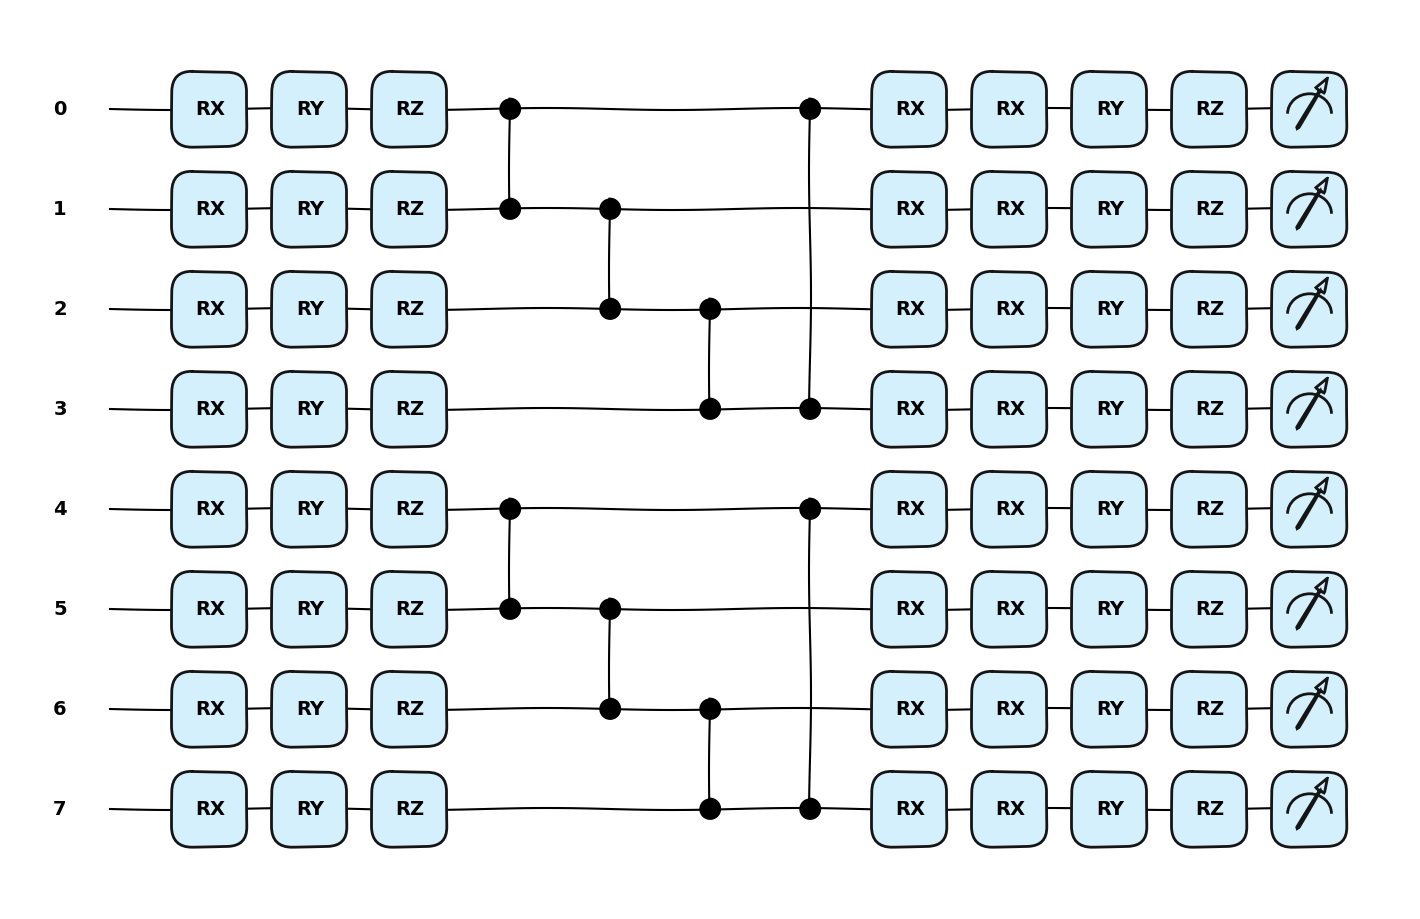

In [93]:
def variational_rotation_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[i][0], wires=wire)
        qml.RY(phi=phi[i][1], wires=wire)
        qml.RZ(phi=phi[i][2], wires=wire)


def circular_entangling_layer(
    wires: list[int],
    ):
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    for w0, w1 in zip(wires, wires[1:]):
        qml.CZ(wires=[w0, w1])
    if len(wires) != 2:
        qml.CZ(wires=[wires[0], wires[-1]]) # Entangle the first and last qubit.


def single_rotation_encoding_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[i], wires=wire)


def variational_encoding_pqc(
    wires: list[int],
    n_layers: int,
    var_thetas: np.ndarray,
    enc_inputs: np.ndarray,
    ):
    n_var_rotations = 3
    n_wires = len(wires)
    d = n_wires
    
    var_thetas = np.asarray(var_thetas)
    assert var_thetas.shape == (n_layers+1, d, n_var_rotations), "var_thetas must have shape (n_layers+1, d, n_var_rotations)"
    
    enc_inputs = np.asarray(enc_inputs)
    assert enc_inputs.shape == (n_layers, d), "enc_inputs must have shape (n_layers, d)"
    
    for l in range(n_layers):
        variational_rotation_layer(wires, var_thetas[l])
        circular_entangling_layer(wires)
        single_rotation_encoding_layer(wires, enc_inputs[l])
    variational_rotation_layer(wires, var_thetas[n_layers])


def entangle_agents_phi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def circuit(
    wires: list,
    d: int, # qubit dimensions for each agent
    n: int, # number of agents
    n_layers: int,
    agents_var_thetas: np.ndarray,
    agents_enc_inputs: np.ndarray,
    initial_state_vector: np.ndarray = None,
    ):
    # n_wires = len(wires)
    
    # for w in wires:
    #     # qml.Hadamard(wires=w)
    #     qml.RX()
    
    # Variational parameters.
    # symbol_superscript_index = None
    n_var_rotations = 3
    
    agents_var_thetas = np.asarray(agents_var_thetas)
    assert agents_var_thetas.shape == (n, n_layers+1, d, n_var_rotations), "agents_var_thetas must have shape (n, n_layers+1, d, n_var_rotations)"
    
    agents_enc_inputs = np.asarray(agents_enc_inputs)
    assert agents_enc_inputs.shape == (n, n_layers, d), "agents_enc_inputs must have shape (n, n_layers, d)"
    
    # var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    # var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))
    
    
    # for l in range(n_layers):
    #     variational_rotation_layer(wires, var_thetas[l])
    #     circular_entangling_layer(wires)
    #     single_rotation_encoding_layer(wires, enc_inputs[l])
    # variational_rotation_layer(wires, var_thetas[n_layers])
    
    measurements = []
    
    # entangle_agents_phi_plus(wires, d, n)
    
    # Prepare initial state.
    if isinstance(initial_state_vector, str):
        if initial_state_vector == 'phi+':
            entangle_agents_phi_plus(wires, d, n)
    elif initial_state_vector is not None:
        qml.QubitStateVector(initial_state_vector, wires=wires)

    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        variational_encoding_pqc(
            wires[qidx:qidx+d],
            n_layers,
            agents_var_thetas[aidx],
            agents_enc_inputs[aidx],
            )
    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
        obs = reduce((lambda a, b: a @ b), ops)
        measurements.append(qml.expval(obs))
        measurements.append(qml.expval(-obs))
    
    # return qml.expval(obs), qml.expval(-obs), qml.state()
    # return np.asarray(measurements)
    return np.asarray(measurements)
    # return *measurements, qml.state()
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(-(qml.PauliZ(0) @ qml.PauliZ(1))), qml.state()
    # return qml.expval(obs), qml.expval(reduce(lambda a, b: a @ b, [qml.PauliX(w) for w in wires])), qml.state()


n = 2
d = 4
wires = list(range(n * d))

n_layers = 1
agents_var_thetas = np.random.uniform(size=(n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(size=(n, n_layers, d))


dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

qml.draw_mpl(qnode, wire_order=wires, style="pennylane")(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
# print(qml.draw(qnode, wire_order=wires)(wires, n_layers, var_thetas, enc_inputs))

In [94]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)
# meas = np.asarray(meas)
# np.concatenate(meas).reshape((n, 2))

def softmax(x, axis=None):
    return np.exp(x)/np.sum(np.exp(x), axis=axis)

meas, softmax(meas)

(tensor([[ 0.08390505, -0.08390505],
         [ 0.08129592, -0.08129592]], requires_grad=True),
 tensor([[0.2709563 , 0.22909745],
         [0.27025027, 0.22969598]], requires_grad=True))

In [95]:
# Compute matrix representation for entire circuit.
U = qml.matrix(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
U.shape # for 8 qubits is (256, 256)

(256, 256)

In [96]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(256, 256)

In [97]:
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state_vector

array([-0.01098116+1.10609929e-01j,  0.04324885-1.18206291e-02j,
       -0.06370227+3.39463786e-02j,  0.03981033+1.99066151e-02j,
        0.03288141-4.68409541e-02j,  0.12052635+2.49005959e-02j,
        0.02431425+1.19737101e-02j,  0.02185121+4.46535987e-02j,
       -0.06090817+6.36930630e-02j,  0.04197425+2.04656240e-02j,
       -0.03796999-2.82375187e-03j,  0.01916191+2.50741035e-02j,
        0.02806231-1.84555198e-02j,  0.0496128 +3.69888749e-02j,
       -0.00656731-1.65742357e-02j, -0.01568696+4.69467616e-02j,
       -0.03732284+2.83221946e-02j,  0.01496183+9.64406055e-03j,
       -0.02752194-3.89255821e-02j,  0.0099255 +4.36808554e-02j,
        0.02304466-1.21198354e-02j,  0.02556835+4.22429695e-02j,
       -0.00129443-2.17615788e-02j, -0.00659001+1.14894010e-02j,
       -0.02932438-1.94062286e-02j, -0.00495137+2.68618456e-03j,
        0.00721032-1.38371893e-02j, -0.09893743-2.18521221e-02j,
        0.03033963+6.68065885e-03j,  0.0003966 +2.48036548e-02j,
        0.10264317+3.5910

(tensor([[ 0.26500229, -0.26500229],
         [-0.25083544,  0.25083544]], requires_grad=True),
 tensor([[0.31530468, 0.18558905],
         [0.18823697, 0.3108693 ]], requires_grad=True))

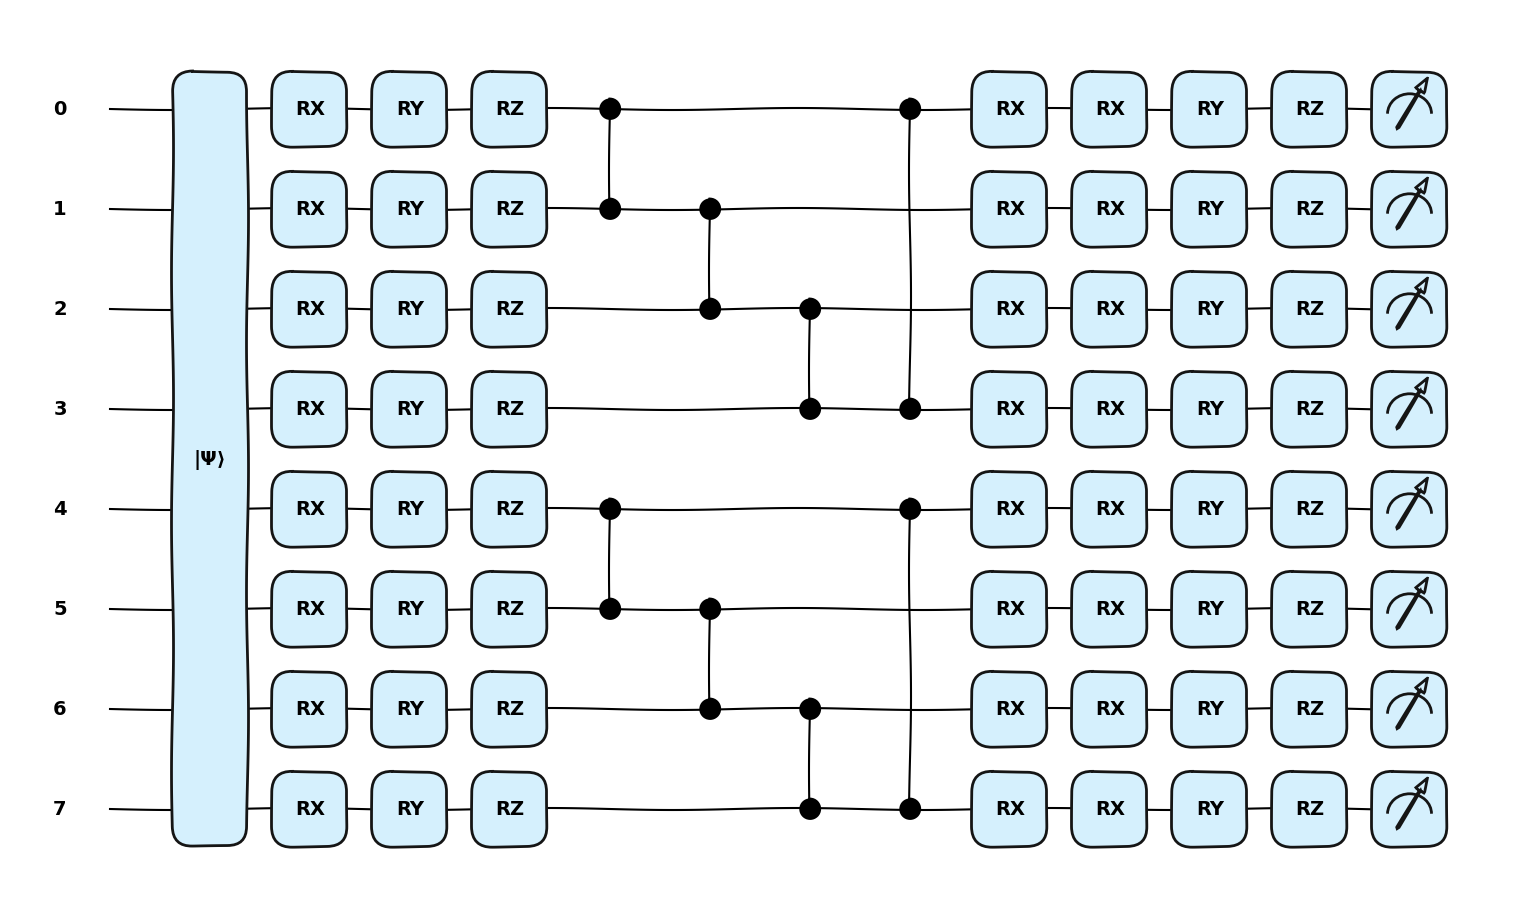

In [98]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane")(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

meas, softmax(meas)

In [99]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

# Try different parameters.
history = []
for i in range(100):
    tmp_agents_var_thetas = np.random.uniform(size=(n, n_layers+1, d, 3))
    tmp_agents_enc_inputs = np.random.uniform(size=(n, n_layers, d))
    meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
    meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

    meas, softmax(meas), np.argmax(softmax(meas), axis=1)
    
    history.append(np.argmax(softmax(meas), axis=1))

# Determine how many times each row of actions occurred.
np.unique(np.asarray(history), axis=0, return_counts=True)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([14, 64,  5, 17]))

In [100]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

# Try different parameters.
history = []
for i in range(100):
    tmp_agents_var_thetas = np.random.uniform(size=(n, n_layers+1, d, 3))
    tmp_agents_enc_inputs = np.random.uniform(size=(n, n_layers, d))
    meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
    meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

    meas, softmax(meas), np.argmax(softmax(meas), axis=1)
    
    history.append(np.argmax(softmax(meas), axis=1))

# Determine how many times each row of actions occurred.
np.unique(np.asarray(history), axis=0, return_counts=True)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([ 9, 23, 24, 44]))

In [101]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi+'

# Try different parameters.
history = []
for i in range(100):
    tmp_agents_var_thetas = np.random.uniform(size=(n, n_layers+1, d, 3))
    tmp_agents_enc_inputs = np.random.uniform(size=(n, n_layers, d))
    meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
    meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

    meas, softmax(meas), np.argmax(softmax(meas), axis=1)
    
    history.append(np.argmax(softmax(meas), axis=1))

# Determine how many times each row of actions occurred.
np.unique(np.asarray(history), axis=0, return_counts=True)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([59, 15, 22,  4]))